In [284]:
import pandas as pd
import numpy as np
import knnimpute
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import Imputer,StandardScaler, LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from math import sqrt

In [215]:
data = pd.read_csv('House_Prediction_Data.csv')

In [218]:
data = data.loc[:, data.isnull().mean() < 0.8]

(1460, 77)

In [223]:
data_numeric = data._get_numeric_data()
data_categorical = data.select_dtypes(include=[np.object])
#data_numeric = data.select_dtypes(include=[np.number])

# One Hot Encoding

In [251]:
le = LabelEncoder()
for i in data_categorical.columns.values:
    data_categorical[i] = le.fit_transform(data_categorical[i].astype(str))
data_categorical.head()

C:\Users\Siddh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,0,0,0,0,1,0,1,0,0,0,...,2,6,5,1,1,4,4,2,8,4
1,0,0,0,0,1,1,1,0,0,0,...,3,6,4,1,1,4,4,2,8,4
2,0,0,1,0,1,0,1,0,0,0,...,2,6,4,1,1,4,4,2,8,4
3,0,0,1,0,1,0,1,0,0,0,...,2,6,2,5,2,4,4,2,8,0
4,0,0,1,0,1,1,1,0,0,0,...,2,6,4,1,1,4,4,2,8,4


In [256]:
model_data = pd.concat([data_numeric, data_categorical], axis = 1)

In [258]:
columns_list = model_data.columns

In [260]:
imp = Imputer(missing_values='NaN', strategy='median', axis=1)
model_data = pd.DataFrame(imp.fit_transform(model_data), columns= columns_list)

In [261]:
model_data.head()

,Id,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,1.0,208500.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,...,2.0,6.0,5.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
1,2.0,181500.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,...,3.0,6.0,4.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
2,3.0,223500.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,...,2.0,6.0,4.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
3,4.0,140000.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,...,2.0,6.0,2.0,5.0,2.0,4.0,4.0,2.0,8.0,0.0
4,5.0,250000.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,...,2.0,6.0,4.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0


In [273]:
#model_data = model_data.drop('Id', axis = 1)

X= model_data.iloc[:,1:]
y = model_data.iloc[:,0]
y.head()
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,2.0,6.0,5.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,3.0,6.0,4.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,2.0,6.0,4.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,2.0,6.0,2.0,5.0,2.0,4.0,4.0,2.0,8.0,0.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,2.0,6.0,4.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0


In [274]:
X_train,X_test, y_train,  y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [171]:
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std  = std_scale.transform(X_test)

In [285]:
samples = [1, 2, 4, 6, 8, 10]

# Creating lists to contain performance metric results
explained_list = []
rmse_list = []
r2_list = []

# Implementing decision tree regression at different minimum samples
for i in range(len(samples)):
    tree = DecisionTreeRegressor(max_depth = 8, min_samples_leaf = samples[i])
    tree.fit(X_train, y_train)
    pred = tree.predict(X_test)
    
    explained = explained_variance_score(y_test, pred)
    explained_list.append(explained)
    
    rmse = sqrt(mean_squared_error(y_test, pred))
    rmse_list.append(rmse)
    
    r2 = r2_score(y_test, pred)
    r2_list.append(r2)

print(explained_list)
print(rmse_list)
print(r2_list)

[0.7847253056463228, 0.7609789901769121, 0.695972977294233, 0.7394274280700415, 0.7414202480210368, 0.7956879758713684]
[36505.44472796055, 38447.96120513504, 43367.320243028495, 40253.4205602557, 40134.94316142046, 35631.80076628133]
[0.7843478116365532, 0.7607867602772354, 0.6956566922716232, 0.7377930711378258, 0.7393343005272437, 0.7945462251444977]


In [172]:
data_numeric.iloc[:,1].head()

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: 1, dtype: float64

In [173]:
estimators = []
avg_error_all_models_nested_cv = []
std_error_all_models_nested_cv = []
avg_Rsquare_all_models_nested_cv = []
std_Rsquare_all_models_nested_cv = []

In [174]:
def nested_cv_evaluation(estimator_type, parameters, X_train, y_train):
    
    # set the number of iterations to do
    NUM_TRIALS = 5
    nested_scores_err = np.zeros(NUM_TRIALS)
    nested_scores_r2 = np.zeros(NUM_TRIALS)
    
    for i in range(NUM_TRIALS):
    
        # Choose cross-validation techniques for the inner and outer loops,
        # independently of the dataset.
        inner_cv = KFold(n_splits=3, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    
        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator=estimator_type, 
                           param_grid=parameters, 
                           cv=inner_cv)
        clf.fit(X_train, y_train)

        # Nested CV with parameter optimization
        nested_score_error = cross_val_score(clf, X_train, y_train, cv=outer_cv, scoring='neg_mean_squared_error')
        nested_score_r2 = cross_val_score(clf, X_train, y_train, cv=outer_cv, scoring='r2')
        
        # Store values for reporting
        nested_scores_err[i] = nested_score_error.mean()
        nested_scores_r2[i] = nested_score_r2.mean()
         
    estimators.append(estimator_type)
    avg_error_all_models_nested_cv.append(nested_scores_err.mean())
    std_error_all_models_nested_cv.append(nested_scores_err.std())
    avg_Rsquare_all_models_nested_cv.append(nested_scores_r2.mean())
    std_Rsquare_all_models_nested_cv.append(nested_scores_r2.std())
    
    #std_all_models_nested_cv.append(nested_scores.std())
    print("Average error is {0} and standard deviation is {1}".format(nested_scores_err.mean(), nested_scores_err.std()))
    print("Average R-Square is {0} and standard deviation is {1}".format(nested_scores_r2.mean(), nested_scores_r2.std()))

In [180]:
def feature_selection_func(estimator, params, X_train, y_train):
    sfs1 = sfs(estimator, k_features='best', forward=True, floating=False, 
              scoring='neg_mean_squared_error', cv=10)

    sfs2 = sfs1.fit(X, y)
    fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err')
    plt.title('Sequential Forward Selection (w. StdErr)')
    plt.grid()
    plt.show()
    print('Selected features:', sfs2.k_feature_idx_)
    X_train_sfs = sfs2.transform(X_train)
    X_test_sfs = sfs2.transform(X_test)
    nested_cv_evaluation(estimator, params, X_train_sfs, y_train)

In [275]:
param = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
lin_reg = LinearRegression()
nested_cv_evaluation(lin_reg, param, X_train, y_train)

Average error is -1626958657.0579617 and standard deviation is 202645469.2602962
Average R-Square is 0.7277497055922806 and standard deviation is 0.04725616370474712


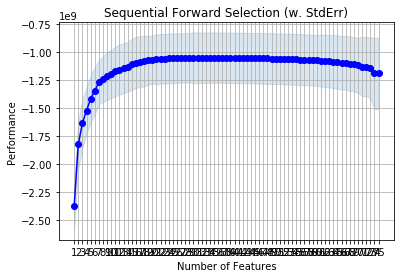

Selected features: (0, 2, 3, 4, 5, 7, 10, 15, 16, 21, 24, 25, 27, 31, 32, 35, 36, 37, 39, 41, 42, 44, 46, 52, 53, 56, 57, 58, 59, 65, 66, 67, 72, 74)
Average error is -1275660784.0466805 and standard deviation is 91915024.50444652
Average R-Square is 0.7920362321593636 and standard deviation is 0.022174849880484442


In [276]:
# Linear Regression with feature selection
feature_selection_func(lin_reg, param, X_train, y_train)